- **Note:** Before running any code cells, please update the paths in the notebook so they point to your local copy of the **UOTReg** folder.

In [1]:
# Change this to the path to your folder
result_folder = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'

In [2]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
os.chdir(result_folder)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np
import random
import math
from typing import Tuple

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT_new


# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


In [3]:
import scanpy as sc

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
statefate = sc.read(result_folder +  "data/timedata/scrna-statefate/invitro-hvg.h5ad")

# Note: this is the top 1000 HVGs of embryoid, already normalized to 1e4 and log1p transformed
print(statefate.shape)


(130861, 1622)


In [4]:
# get the pandas data frame we work on
statefate_pc = statefate.obsm['X_pca'][:,0:20]
print(type(statefate_pc))
print(statefate_pc.shape)

statefate_pc_df = pd.DataFrame(
    data=statefate_pc,
    index=statefate.obs_names,               # Row index from original AnnData object
    columns=[f"PC{i+1}" for i in range(statefate_pc.shape[1])]  # Column names as PC1, PC2, ...
)

print(type(statefate_pc_df))  # Should be <class 'pandas.DataFrame'>
print(statefate_pc_df.shape)

# get the time list
cells_meta = statefate.obs
unique_time = statefate.obs['time'].unique().to_list()
print(unique_time)

<class 'numpy.ndarray'>
(130861, 20)
<class 'pandas.core.frame.DataFrame'>
(130861, 20)
[6, 4, 2]


In [5]:
Y_time_samplers = []
datasets = []

# get diseased samplers
for id in unique_time:
    print(id)
    X_k = statefate_pc_df[statefate.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

6
54116
4
48496
2
28249


## Calculate weight

In [6]:
# benchmarking setup
# targets: 7.5, 13.5, 19.5

timelist = [2, 4, 6]
predict_time = 4

X = timelist.copy()
X = np.array(X)

## Local Frechet coefficient
# Bandwidth selection - Silverman's rule of thumb for Gaussian kernel
std_dev = np.std(X)
h = 1.06 * std_dev * len(X) ** (-1/5)
# h = 5
print(h)

# Calculate moments
mu_0 = calculate_moments(X, predict_time, h, 0)
mu_1 = calculate_moments(X, predict_time, h, 1)
mu_2 = calculate_moments(X, predict_time, h, 2)

# Calculate empirical weights
ALPHAS_LF = calculate_weights(X, predict_time, h, mu_0, mu_1, mu_2)

print("mu_0:", mu_0)
print("mu_1:", mu_1)
print("mu_2:", mu_2)
print("Empirical weights s_in(x, h):", ALPHAS_LF)

1.3895237699571201
mu_0: 0.1636364776616028
mu_1: 0.0
mu_2: 0.27173630923048264
Empirical weights s_in(x, h): [np.float64(0.2075762026854033), np.float64(0.5848475946291934), np.float64(0.2075762026854033)]


In [7]:
# setup samplers
Ysamplers = Y_time_samplers.copy()
    
K_time = len(ALPHAS_LF)
CLASSES_time = [i for i in range(K_time)]

In [8]:
# hyperparameters 
DIM = statefate_pc.shape[1]
NUM = K_time
device = "cpu"
bn = False

BATCH_SIZE = 64
G_ITERS, D_ITERS, T_ITERS = 50, 50, 10
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Parameters for T and D
input_size = DIM # DIM
n_outputs = NUM # number of distributions
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 196
task_specific_hidden_size_D = 196
dropout_rate = 0.05

# paramerters for G
size=256
input_dim = DIM
num_layers = 4

In [9]:
D = Seperate_D(input_size, task_specific_hidden_size_D, n_hidden, n_outputs, bn, dropout_rate)
D.apply(weights_init)
print(D)


# Seperate T
T = Seperate_T(input_size, task_specific_hidden_size_T, n_hidden, n_outputs, output_size, bn, dropout_rate)
T.apply(weights_init)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))

criterions = [nn.MSELoss() for _ in range(n_outputs)]
T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

print(n_outputs)

Seperate_D(
  (task_nets): ModuleList(
    (0-2): 3 x FFNN(
      (hidden): ModuleList(
        (0): Linear(in_features=20, out_features=196, bias=True)
        (1-4): 4 x Linear(in_features=196, out_features=196, bias=True)
        (5): Linear(in_features=196, out_features=1, bias=True)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
)
T params: 487512
D params: 476283
3


In [10]:
# For now DIM_Z = DIM_X
Z_sampler = distributions.StandardNormalSampler(dim=input_dim, device=device)

# Instantiate encoder and decoder
encoder = Encoder(nin=DIM, n_latent=size, size=size, num_layers=num_layers, dropout_rate=0.05)
G = Gnet(input_dim=input_dim, output_dim=DIM, size=size, num_layers=num_layers, dropout_rate=dropout_rate)

In [11]:
# # Initialization

# G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
# loss = np.inf

# G.train(True)

# for iteration in tqdm(range(10000)):
#     Z = Z_sampler.sample(BATCH_SIZE).detach() * 6
#     loss = F.mse_loss(Z, G(Z))
#     loss.backward()
#     G_opt.step(); G_opt.zero_grad()
#     if loss.item() < 1e-2:
#         break

In [12]:
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
G.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/G_statefate20_256_Dayall_ini.pth"))

<All keys matched successfully>

In [13]:
print('G params:', np.sum([np.prod(p.shape) for p in G.parameters()]))

# G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)

G params: 207892


## Visualization

In [14]:
# Step 1: Perform UMAP on `embryoid_pc_df`
statefate_pc_df_further = statefate_pc_df.copy()
statefate_pc_df_further['time'] = statefate.obs['time']
sampled_df = statefate_pc_df_further.sample(n=40000, random_state=25)

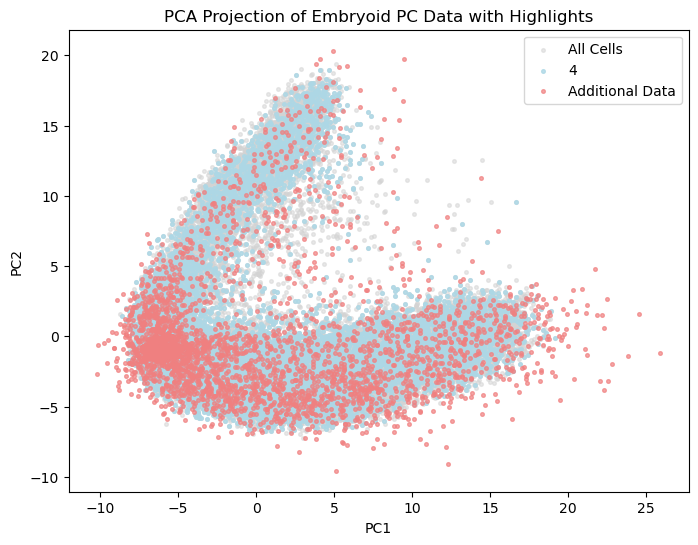

In [15]:
# visualize current barycenter - pca

# Step 1: Plot using first two PCs of `embryoid_pc_df`
plt.figure(figsize=(8, 6))

# Plot all cells in light grey
plt.scatter(
    sampled_df.iloc[:, 0], sampled_df.iloc[:, 1],
    color="lightgrey", label="All Cells", alpha=0.5, s=7
)

# Emphasize specific groups in light blue and light red
highlight_colors = {4: "lightblue"}
# highlight_colors = {"Day 12-15": "lightblue", "Day 06-09": "yellow", "Day 18-21": "purple"}
group_labels = sampled_df['time']  # Assuming `time` column exists with group labels

for group, color in highlight_colors.items():
    mask = group_labels == group
    plt.scatter(
        sampled_df.iloc[mask.to_numpy(), 0], sampled_df.iloc[mask.to_numpy(), 1],
        color=color, label=group, alpha=0.8, s=7
    )

# Step 4: plot additional data in dark grey
X_np = G(Z_sampler.sample(3000)).detach().numpy()
plt.scatter(
    X_np[:, 0], X_np[:, 1],
    color="lightcoral", label="Additional Data", alpha=0.7, s=7
)

# Finalizing the plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA Projection of Embryoid PC Data with Highlights")
plt.show()

## Training

In [16]:
G_loss_history = []

Iteration 2100


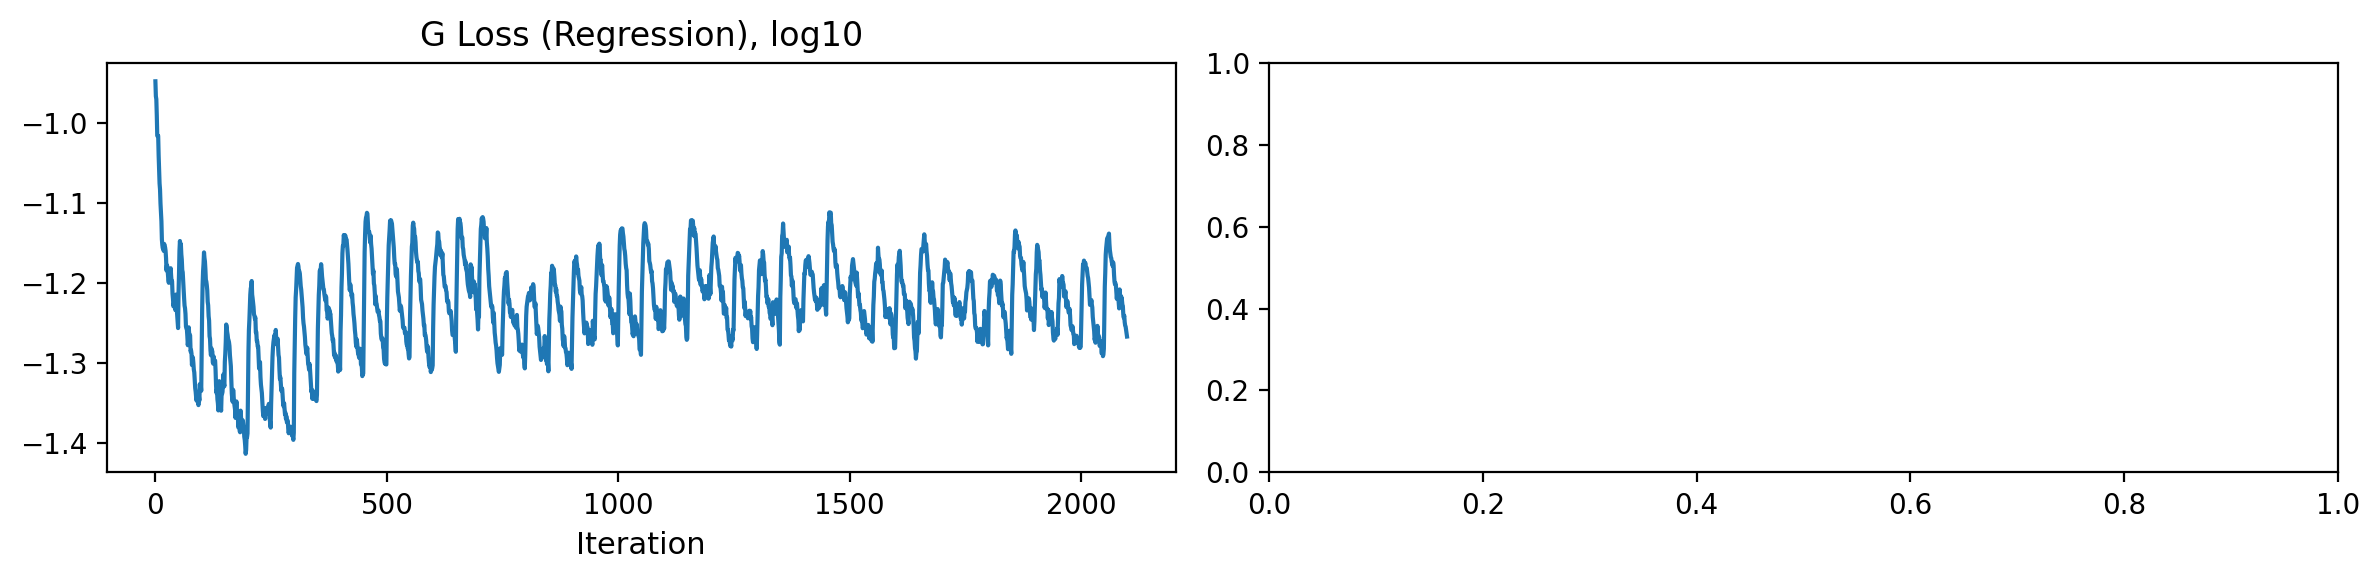

plt!!!!!!!!


In [ ]:
# some parameters
MAX_ITER = 200000

# joint training T, then train the network distributedly
BATCH_SIZE = 64
BATCH_SIZE_G = 128

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

# Main Training Loop
it = 0 # number of iterations
G_time = 0 # numbers of G updating
loss_at_start = 0
start_losses = [] # a list of the first G_losses after updating T

while it < MAX_ITER:
    
    G_time += 1

    # Optimize T and D
    # it = optimize_T_and_D(it, G, T, D, T_opt, D_opt, Z_sampler, Ysamplers, NUM, DIM, BATCH_SIZE, ALPHAS_LF, D_ITERS, T_ITERS)
    it = optimize_T_and_D_UOT_new(it, G, T, D, T_opt, D_opt, Z_sampler, Ysamplers, NUM, DIM, BATCH_SIZE, ALPHAS_LF, D_ITERS, T_ITERS, tau=1)

    loss_at_start = optimize_G(G, T, G_opt, Z_sampler, ALPHAS_LF, NUM, DIM, G_ITERS, BATCH_SIZE_G, G_loss_history)
    start_losses.append(loss_at_start)

    # Plot metrics
    # Plotting
    if True:
        clear_output(wait=True)
        print('Iteration', it)

        # Plotting Metrics
        fig, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=200)

        axes[0].set_title('G Loss (Regression), log10', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].plot(np.log10(ewma(G_loss_history, span=10)))

        fig.tight_layout(); plt.show(); plt.close(fig)

        print("plt!!!!!!!!")

    # Early stopping or checkpoint saving
    if G_time > 41:
        break

In [ ]:
# # This is revision, new estimation saving
# save_path = "/Path/to/your/folder/"
# torch.save(G.state_dict(), save_path+"G_statefate20_256_Day4_40_tau1.pth")